<a href="https://colab.research.google.com/github/liminovna/HSE_NLP_ASSIGNMENTS/blob/main/module2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [ ]:
! wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/wiki_data.txt.zip
!unzip -o wiki_data.txt.zip

--2025-01-11 20:52:27--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/wiki_data.txt.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/wiki_data.txt.zip [following]
--2025-01-11 20:52:27--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/wiki_data.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18709143 (18M) [application/zip]
Saving to: ‘wiki_data.txt.zip’

wiki_data.txt.zip   100%[===================>]  17.84M  90.8MB/s    in 0.2s    

2025-01-11 20:52:29 (90.8 MB/s) - ‘wiki_da

In [ ]:
# %pip install matplotlib pandas
# %pip install --upgrade keras
# %pip install torch torchvision torchaudio

In [ ]:
# import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.5.0


In [ ]:
wiki = open('wiki_data.txt').read().split('\n')

In [ ]:
wiki[0]

'######Новостройка (Нижегородская область)############Новостро́йка — сельский посёлок в Дивеевском районе Нижегородской области. Входит в состав Сатисского сельсовета.############Посёлок расположен в 12,5 км к югу от села Дивеева и 1 км к западу от города Сарова, на правом берегу реки Вичкинза (правый приток реки Сатис). Окружён смешанными лесами. Соединён асфальтовой дорогой с посёлком Цыгановка (1,5 км) и грунтовыми просёлочными дорогами с посёлком Сатис (3,5 км). Название Новостройка является сугубо официальным, местное население использует исключительно альтернативное название — Хитрый. Употребляется языковой оборот «…на Хитром». Ранее используемые названия — Песчаный, Известковый.############Основан в 1920-х годах переселенцами из соседних сёл Аламасово и Нарышкино (расположенных соответственно в 8 и 14 км к западу в Вознесенском районе).############Традиционно в посёлке жили рабочие совхоза «Вперёд» (центр в посёлке Сатис). Возле посёлка расположен карьер где активно добывали дол

In [ ]:
!pip install pymystem3

In [ ]:
from pymystem3 import Mystem

mystem = Mystem(disambiguation=True)

In [ ]:
import re
def preprocess(text):
    text = re.sub('#+', ' ', text.lower())
    tokens = ' '.join([w['analysis'][0]['lex'] if w.get('analysis') else w['text'] for w in mystem.analyze(text)]).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [ ]:
from collections import Counter

In [ ]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

12772

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [ ]:
vocab_size = len(id2word)

In [ ]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [ ]:
model = keras.Sequential()

In [ ]:
# skip gram
def gen_batches_sg(sentences, window = 5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [ ]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=10)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.8488 - loss: 0.3525 - val_accuracy: 0.8182 - val_loss: 0.4281
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - accuracy: 0.8495 - loss: 0.3493 - val_accuracy: 0.8402 - val_loss: 0.3802
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - accuracy: 0.8484 - loss: 0.3546 - val_accuracy: 0.8492 - val_loss: 0.3656
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - accuracy: 0.8482 - loss: 0.3561 - val_accuracy: 0.8396 - val_loss: 0.3701
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - accuracy: 0.8505 - loss: 0.3487 - val_accuracy: 0.8411 - val_loss: 0.3646
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.8513 - loss: 0.3470 - val_accuracy: 0.8291 - val_loss: 0.4120
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - accuracy: 0.8516 - loss: 0.3473 - val_accuracy: 0.8545 - val_loss: 0.3478
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - ac

In [ ]:
embeddings = model.layers[2].get_weights()[0]

In [ ]:
most_similar('звезда', embeddings)

['звезда',
 'голливудский',
 'карлик',
 'планета',
 'звездный',
 'сатурн',
 'hd',
 'солнце',
 'гигант',
 'созвездие']

In [ ]:
# cbow
def gen_batches_cbow(sentences, window = 5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [ ]:
#cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(7,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.build([(None, 1), (None, 7)])

In [ ]:
model.fit(gen_batches_cbow(sentences[:19000], window=7),
          validation_data=gen_batches_cbow(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=10)

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.8051 - loss: 0.4348 - val_accuracy: 0.8617 - val_loss: 0.3331
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.8678 - loss: 0.3176 - val_accuracy: 0.8842 - val_loss: 0.2819
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.8887 - loss: 0.2697 - val_accuracy: 0.8931 - val_loss: 0.2646
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.9010 - loss: 0.2432 - val_accuracy: 0.8979 - val_loss: 0.2494
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.9089 - loss: 0.2243 - val_accuracy: 0.8967 - val_loss: 0.2551
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - accuracy: 0.9127 - loss: 0.2158 - val_accuracy: 0.8842 - val_loss: 0.2974
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.9200 - loss: 0.1983 - val_accuracy: 0.8944 - val_loss: 0.2672
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.9210 -

In [ ]:
most_similar('город', embeddings)

['город', 'который', 'район', 'они', 'год', 'она', 'часть', 'а', 'и', 'он']

In [ ]:
most_similar('кино', embeddings)

['кино',
 'режиссер',
 'актер',
 'кинофильм',
 'сценарист',
 'кинорежиссер',
 'телевизионный',
 'актриса',
 'комедийный',
 'телефильм']

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [ ]:
import gensim

In [ ]:
gensim.__version__

'4.3.3'

In [ ]:
texts = [preprocess(text) for text in wiki]

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=100,
                             min_count=50,
                             max_vocab_size=9000,
                             window=6,
                             epochs=5)

CPU times: user 40.3 s, sys: 197 ms, total: 40.5 s
Wall time: 25.9 s


In [ ]:
w2v.wv.most_similar('свобода')

[('преступление', 0.6599746346473694),
 ('осуждать', 0.6474905014038086),
 ('ответственность', 0.6295432448387146),
 ('заключение', 0.6204968690872192),
 ('религиозный', 0.5848475694656372),
 ('гражданин', 0.580096423625946),
 ('право', 0.5666305422782898),
 ('уголовный', 0.557969868183136),
 ('личность', 0.5366224050521851),
 ('акт', 0.522919237613678)]

In [ ]:
%%time
ft = gensim.models.FastText(texts, min_n=3, max_n=10)

CPU times: user 7min 5s, sys: 1.22 s, total: 7min 6s
Wall time: 4min 19s


In [ ]:
ft.wv.most_similar('свобода')

[('свободно', 0.8168971538543701),
 ('правосудие', 0.726274311542511),
 ('вправо', 0.7167567610740662),
 ('свободноживущий', 0.7163036465644836),
 ('правда', 0.7140752077102661),
 ('несправедливо', 0.7045143246650696),
 ('право', 0.7037718892097473),
 ('правонарушение', 0.7004514932632446),
 ('сво', 0.6994577050209045),
 ('правонарушитель', 0.696229100227356)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор.
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%.

In [1]:
! wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/word_embeddings/labeled.csv

--2025-01-12 13:35:35--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/word_embeddings/labeled.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/word_embeddings/labeled.csv [following]
--2025-01-12 13:35:37--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/word_embeddings/labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4669913 (4.5M) [application/octet-stream]
Saving to: ‘labeled.csv’

labeled.csv         100%[===================>]   4.45M  --.-KB/s    in 0.09s   

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('labeled.csv')

In [4]:
!pip install pymystem3

In [5]:
from pymystem3 import Mystem
from string import punctuation

mystem = Mystem(disambiguation=True)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [6]:
import re
def preprocess(text):
    text = re.sub('#+', ' ', text.lower())
    tokens = ' '.join([w['analysis'][0]['lex'] if w.get('analysis') else w['text'] for w in mystem.analyze(text)]).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [7]:
data['norm_text'] = data.comment.apply(preprocess)

In [12]:
data.head()

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд, то, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновлять, дебил, это, тоже, не, ос..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убеждать, 6, страничный, пдф, в, то, ..."


In [8]:
from collections import Counter

In [9]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6310

In [10]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [11]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [14]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.5.0


In [15]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [45]:
inputs = keras.layers.Input(shape=(100,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = keras.layers.Lambda(lambda x: x.mean(axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = keras.layers.Dense(1, activation='sigmoid')(mean)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=10)

Epoch 1/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6517 - loss: 0.6382 - val_accuracy: 0.6699 - val_loss: 0.5631
Epoch 2/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7041 - loss: 0.5306 - val_accuracy: 0.8266 - val_loss: 0.4673
Epoch 3/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8333 - loss: 0.4246 - val_accuracy: 0.8502 - val_loss: 0.4015
Epoch 4/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8813 - loss: 0.3469 - val_accuracy: 0.8613 - val_loss: 0.3690
Epoch 5/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8953 - loss: 0.3003 - val_accuracy: 0.8738 - val_loss: 0.3527
Epoch 6/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9081 - loss: 0.2686 - val_accuracy: 0.8821 - val_loss: 0.3435
Epoch 7/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9128 - loss: 0.2494 - val_accuracy: 0.8821 - val_loss: 0.3397
Epoch 8/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9267 - loss: 0.2245 - val_accu

In [48]:
import matplotlib.pyplot as plt

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


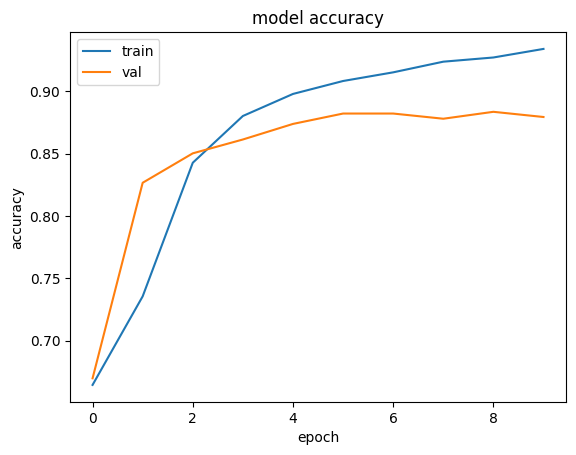

In [49]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.